# Sentiment Analysis Pipeline

Script for NLP project.

Prerequisits: upload training data as "train.csv", multilingual data for evaluation as "multilingual.csv", and generated comments by gpt4 as "gpt4_generated.txt".

## Config

In [ ]:
data_path = "train.csv"
embeddings_path = "embeddings.csv"
multilingual_data_path = "multilingual.csv"
gpt_data_path = "gpt4_generated.txt"

## Imports

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.4 MB/s eta 0:00:00


In [ ]:
import gc
import torch
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from torch import cuda
from tqdm import tqdm
from sklearn.utils import resample
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from transformers import DistilBertTokenizer, DistilBertModel
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
import torch.optim as optim
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

## Read Data

In [ ]:
data = pd.read_csv(data_path)
data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


## Describe Data

In [ ]:
data.sample(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
140908,f20d873943c4b42d,"There were way more than 110,000 Axis prisoner...",0,0,0,0,0,0
16943,2cb38dca87829e50,is more compatible with the subject (a preside...,0,0,0,0,0,0
124151,980b0aab440828b3,Hawkesbury and Nepean Wars \nHello AustralianR...,0,0,0,0,0,0
111205,52eafc65c3e782d7,I removed your speedy deletion tag. Bruce Mil...,0,0,0,0,0,0
16679,2bfa79ae865099f7,Fuck you Fiskeharrison!! Go suck your dad's di...,1,1,1,0,1,0
110848,5108086920e0ae5a,Don't keep changing my page I made please. You...,0,0,0,0,0,0
16678,2bfa65a953d7ec30,""":You can ignore, Jossi took care of it and sh...",0,0,0,0,0,0
21235,37fd835961009eb9,"Needs work. \n\nI started this article, but it...",0,0,0,0,0,0
64932,adbd641798e3fcfb,", Bismuth nanotubes, Graphine",0,0,0,0,0,0
132332,c4256fdf8095ce90,"""== With regards to """"Very Long"""" tag==\nHowev...",0,0,0,0,0,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


## Explore Data

In [ ]:
data.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


0    144277
1     15294
Name: toxic, dtype: int64

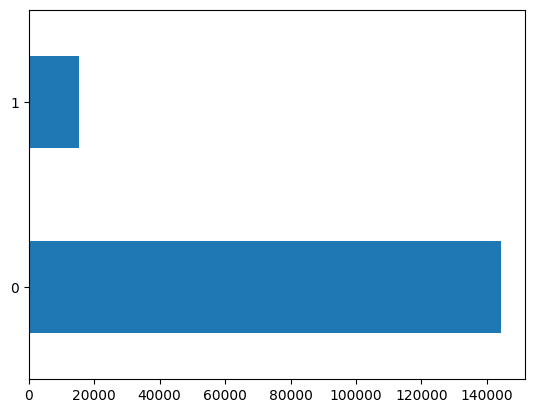

In [ ]:
data["toxic"].value_counts().plot(kind="barh")
data["toxic"].value_counts()

0    157976
1      1595
Name: severe_toxic, dtype: int64

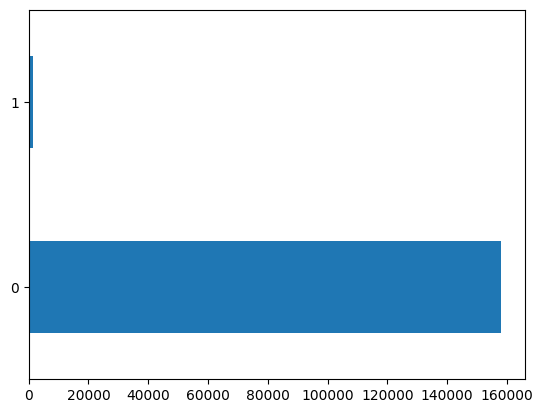

In [ ]:
data["severe_toxic"].value_counts().plot(kind="barh")
data["severe_toxic"].value_counts()

0    151122
1      8449
Name: obscene, dtype: int64

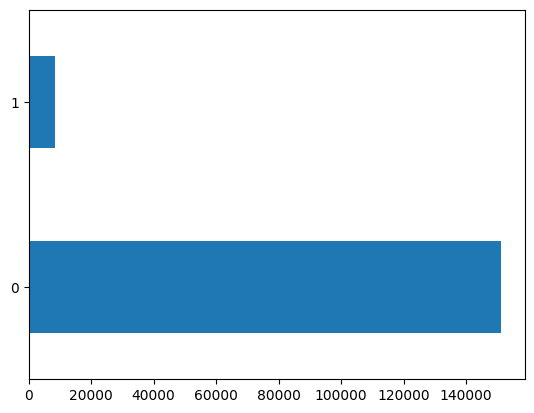

In [ ]:
data["obscene"].value_counts().plot(kind="barh")
data["obscene"].value_counts()

0    159093
1       478
Name: threat, dtype: int64

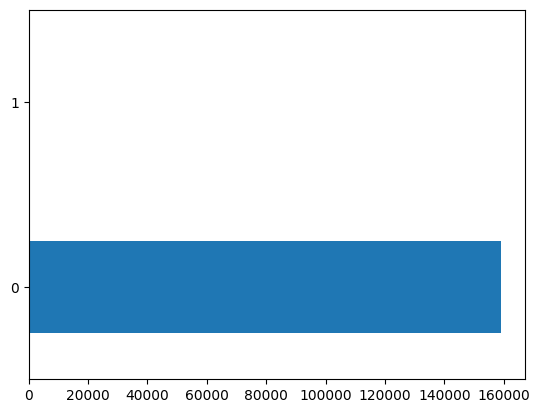

In [ ]:
data["threat"].value_counts().plot(kind="barh")
data["threat"].value_counts()

0    159093
1       478
Name: threat, dtype: int64

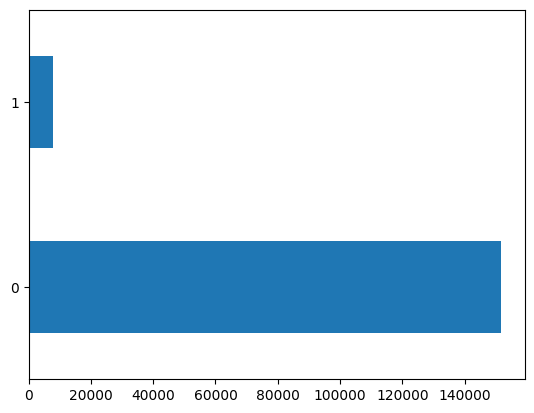

In [ ]:
data["insult"].value_counts().plot(kind="barh")
data["threat"].value_counts()

0    158166
1      1405
Name: identity_hate, dtype: int64

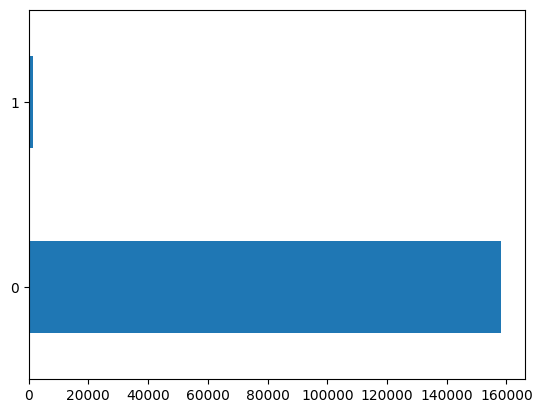

In [ ]:
data["identity_hate"].value_counts().plot(kind="barh")
data["identity_hate"].value_counts()

<ipython-input-14-7e6ce141f653>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), cmap='flare')


<Axes: >

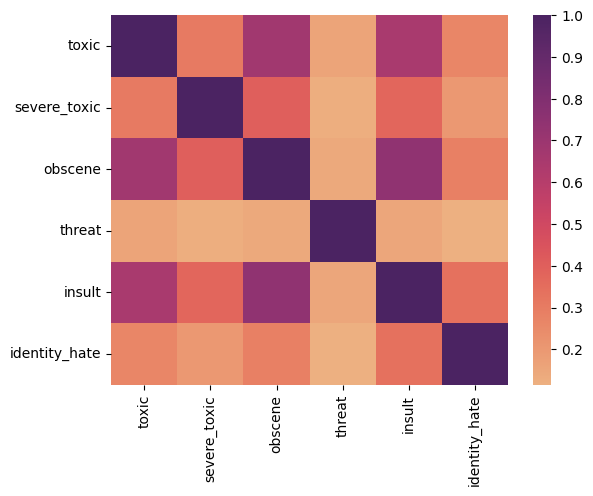

In [ ]:
sns.heatmap(data.corr(), cmap='flare')

## Verify Data Quality

In [ ]:
data.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

No null values - good.

## Preprocessing

### Merge Toxic Columns to Single One

In [ ]:
data = pd.concat([data["comment_text"], 
                  data.drop(
                      ["id", "comment_text"], axis=1
                  ).apply(lambda row: any(row), axis=1)], 
                 axis=1)
data

,comment_text,0
0,Explanation\nWhy the edits made under my usern...,False
1,D'aww! He matches this background colour I'm s...,False
2,"Hey man, I'm really not trying to edit war. It...",False
3,"""\nMore\nI can't make any real suggestions on ...",False
4,"You, sir, are my hero. Any chance you remember...",False
...,...,...
159566,""":::::And for the second time of asking, when ...",False
159567,You should be ashamed of yourself \n\nThat is ...,False
159568,"Spitzer \n\nUmm, theres no actual article for ...",False
159569,And it looks like it was actually you who put ...,False


### Balance Classes

In [ ]:
df_majority = data[data[0]==False]
df_minority = data[data[0]==True]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority),     # to match minority class
                                   random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_downsampled[0].value_counts()

False    16225
True     16225
Name: 0, dtype: int64

In [ ]:
df_downsampled = df_downsampled.sample(frac=1)
df_downsampled

,comment_text,0
153127,Theres nothing rude or uncivilized about my ab...,False
135106,Better believe it. At least I earned a Barnst...,True
62945,"""\n\n Note to Mal \nIf I'm treated differently...",True
51268,P.S. - You banned LisaMinelli. The actresses...,True
121799,Ford's assessment of fellow presidents release...,False
...,...,...
124270,"Zappaz, it remains an unattributed opinion. Wh...",False
69940,"Sorry for any disruption, but please do believ...",False
139521,FUCK U DIRTY INDIAN \n\nI HATE INDIANS...YOU G...,True
159026,"He's just left-handed, and left-handed people ...",True


## Extract Embeddings

(0.0, 1000.0)

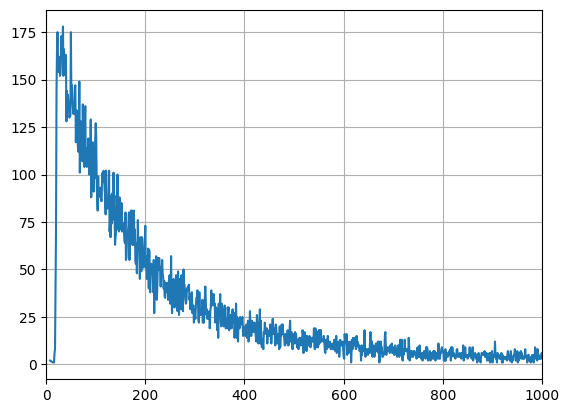

In [ ]:
# let us see distribution of length to define a value of SEQ_LEN
from collections import Counter
from matplotlib import pyplot as plt

cnt = Counter((len(seq) for seq in df_downsampled["comment_text"]))
cnt = sorted(dict(cnt).items())
plt.plot([key for key, val in cnt], [val for key, val in cnt])
plt.grid()
plt.xlim(0, 1000)

In [ ]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 128  # TODO try 400 and 200
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased', truncation=True, do_lower_case=True)
device = "cuda" if cuda.is_available() else "cpu"

In [ ]:
class MultiLabelDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.comment_text
        self.targets = self.data[0]
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor([self.targets[index]], dtype=torch.float)
        }

In [ ]:
ds_downsampled = MultiLabelDataset(df_downsampled.reset_index(drop=True), tokenizer, MAX_LEN)

In [ ]:
embedder_params = {
    'batch_size': TRAIN_BATCH_SIZE,
    'shuffle': False,
    'num_workers': 0
}
ds_loader = DataLoader(ds_downsampled, **embedder_params)

In [ ]:
model = DistilBertModel.from_pretrained("distilbert-base-multilingual-cased")

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model = DistilBertModel.from_pretrained("distilbert-base-multilingual-cased")
model.to(device)

embeddings = []

with torch.no_grad():
    for _, data in tqdm(enumerate(ds_loader)):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        outputs = model(input_ids=ids, attention_mask=mask).last_hidden_state.cpu().detach().numpy()
        for output in outputs:
            embeddings.append(outputs[0].sum(axis=0))

len(embeddings), len(embeddings[0])

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of seq

(32450, 768)

In [ ]:
pd.DataFrame(embeddings)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-12.308391,-44.627308,-20.135336,39.213913,31.702354,10.036917,-70.859932,34.399364,10.997814,-4.441611,...,27.140297,21.933767,-21.144651,-94.754272,13.609601,-40.086437,51.279167,32.189297,-34.696537,-8.747045
1,-12.308391,-44.627308,-20.135336,39.213913,31.702354,10.036917,-70.859932,34.399364,10.997814,-4.441611,...,27.140297,21.933767,-21.144651,-94.754272,13.609601,-40.086437,51.279167,32.189297,-34.696537,-8.747045
2,-12.308391,-44.627308,-20.135336,39.213913,31.702354,10.036917,-70.859932,34.399364,10.997814,-4.441611,...,27.140297,21.933767,-21.144651,-94.754272,13.609601,-40.086437,51.279167,32.189297,-34.696537,-8.747045
3,-12.308391,-44.627308,-20.135336,39.213913,31.702354,10.036917,-70.859932,34.399364,10.997814,-4.441611,...,27.140297,21.933767,-21.144651,-94.754272,13.609601,-40.086437,51.279167,32.189297,-34.696537,-8.747045
4,-15.641595,-31.162598,-13.347409,7.242404,41.068729,-37.694492,-4.333982,16.099094,-0.505679,9.898235,...,41.800507,-8.539954,-26.574781,-73.562004,35.667339,-22.176065,-3.916465,20.129122,1.747074,-9.663159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32445,-16.990000,-59.431591,-24.319271,40.813339,26.953392,19.587029,-46.474041,27.235964,22.671608,-25.501984,...,17.898682,-5.518697,-35.144474,-90.938660,17.643578,-56.534641,38.971146,45.635372,-19.420198,2.737063
32446,-16.990000,-59.431591,-24.319271,40.813339,26.953392,19.587029,-46.474041,27.235964,22.671608,-25.501984,...,17.898682,-5.518697,-35.144474,-90.938660,17.643578,-56.534641,38.971146,45.635372,-19.420198,2.737063
32447,-16.990000,-59.431591,-24.319271,40.813339,26.953392,19.587029,-46.474041,27.235964,22.671608,-25.501984,...,17.898682,-5.518697,-35.144474,-90.938660,17.643578,-56.534641,38.971146,45.635372,-19.420198,2.737063
32448,-32.183319,-45.608925,-4.492823,45.571762,15.294174,-40.207291,-66.778198,26.469563,47.504044,0.387176,...,40.731915,23.692995,-20.166988,-13.652073,36.165169,-57.223766,47.450588,36.436401,-21.646942,-13.716745


In [ ]:
sd_scaler = StandardScaler()
embeddings = sd_scaler.fit_transform(embeddings)
embeddings

array([[-0.56269869, -0.61792909, -1.06611282, ..., -0.38422412,
        -0.89313059, -0.19387966],
       [-0.56269869, -0.61792909, -1.06611282, ..., -0.38422412,
        -0.89313059, -0.19387966],
       [-0.56269869, -0.61792909, -1.06611282, ..., -0.38422412,
        -0.89313059, -0.19387966],
       ...,
       [-0.79373285, -1.41920866, -1.23354917, ...,  0.37693043,
        -0.25408032,  0.55957793],
       [-1.54351263, -0.67105896, -0.44011713, ..., -0.1438043 ,
        -0.34723099, -0.51993538],
       [-1.54351263, -0.67105896, -0.44011713, ..., -0.1438043 ,
        -0.34723099, -0.51993538]])

In [ ]:
pd.DataFrame(embeddings)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.562699,-0.617929,-1.066113,1.017146,-0.496179,0.453536,-1.606114,0.934369,-0.030627,-0.157308,...,0.040609,0.506098,0.357822,-1.392786,-0.686830,-0.379362,1.165472,-0.384224,-0.893131,-0.193880
1,-0.562699,-0.617929,-1.066113,1.017146,-0.496179,0.453536,-1.606114,0.934369,-0.030627,-0.157308,...,0.040609,0.506098,0.357822,-1.392786,-0.686830,-0.379362,1.165472,-0.384224,-0.893131,-0.193880
2,-0.562699,-0.617929,-1.066113,1.017146,-0.496179,0.453536,-1.606114,0.934369,-0.030627,-0.157308,...,0.040609,0.506098,0.357822,-1.392786,-0.686830,-0.379362,1.165472,-0.384224,-0.893131,-0.193880
3,-0.562699,-0.617929,-1.066113,1.017146,-0.496179,0.453536,-1.606114,0.934369,-0.030627,-0.157308,...,0.040609,0.506098,0.357822,-1.392786,-0.686830,-0.379362,1.165472,-0.384224,-0.893131,-0.193880
4,-0.727190,0.110846,-0.794468,-1.277340,0.034724,-1.576300,1.382204,-0.012192,-0.587902,0.478681,...,0.898608,-1.105316,0.109730,-0.641287,0.554497,0.603673,-1.725197,-1.066926,0.631404,-0.253985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32445,-0.793733,-1.419209,-1.233549,1.131932,-0.765358,0.859667,-0.510710,0.563850,0.534898,-1.091360,...,-0.500263,-0.945556,-0.281801,-1.257480,-0.459813,-1.282143,0.520885,0.376930,-0.254080,0.559578
32446,-0.793733,-1.419209,-1.233549,1.131932,-0.765358,0.859667,-0.510710,0.563850,0.534898,-1.091360,...,-0.500263,-0.945556,-0.281801,-1.257480,-0.459813,-1.282143,0.520885,0.376930,-0.254080,0.559578
32447,-0.793733,-1.419209,-1.233549,1.131932,-0.765358,0.859667,-0.510710,0.563850,0.534898,-1.091360,...,-0.500263,-0.945556,-0.281801,-1.257480,-0.459813,-1.282143,0.520885,0.376930,-0.254080,0.559578
32448,-1.543513,-0.671059,-0.440117,1.473427,-1.426224,-1.683160,-1.422764,0.524209,1.737879,0.056855,...,0.836068,0.599124,0.402489,1.483179,0.582513,-1.319966,0.964965,-0.143804,-0.347231,-0.519935


In [ ]:
np.savetxt(embeddings_path, np.array(embeddings, dtype=np.float16), delimiter=",", fmt='%1.8f')

In [ ]:
del embeddings

## Classifier

### Load Data

In [ ]:
csv_embeddings = pd.read_csv(embeddings_path, header=None)
csv_embeddings.columns = [f"emb_{i}" for i in range(csv_embeddings.shape[1])]
csv_embeddings

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_758,emb_759,emb_760,emb_761,emb_762,emb_763,emb_764,emb_765,emb_766,emb_767
0,-0.562500,-0.618164,-1.066406,1.017578,-0.496094,0.453613,-1.606445,0.934570,-0.030624,-0.157349,...,0.040619,0.505859,0.357910,-1.392578,-0.687012,-0.379395,1.165039,-0.384277,-0.893066,-0.193848
1,-0.562500,-0.618164,-1.066406,1.017578,-0.496094,0.453613,-1.606445,0.934570,-0.030624,-0.157349,...,0.040619,0.505859,0.357910,-1.392578,-0.687012,-0.379395,1.165039,-0.384277,-0.893066,-0.193848
2,-0.562500,-0.618164,-1.066406,1.017578,-0.496094,0.453613,-1.606445,0.934570,-0.030624,-0.157349,...,0.040619,0.505859,0.357910,-1.392578,-0.687012,-0.379395,1.165039,-0.384277,-0.893066,-0.193848
3,-0.562500,-0.618164,-1.066406,1.017578,-0.496094,0.453613,-1.606445,0.934570,-0.030624,-0.157349,...,0.040619,0.505859,0.357910,-1.392578,-0.687012,-0.379395,1.165039,-0.384277,-0.893066,-0.193848
4,-0.727051,0.110840,-0.794434,-1.277344,0.034729,-1.576172,1.381836,-0.012192,-0.587891,0.478760,...,0.898438,-1.105469,0.109741,-0.641113,0.554688,0.603516,-1.725586,-1.067383,0.631348,-0.253906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32445,-0.793945,-1.418945,-1.233398,1.131836,-0.765137,0.859863,-0.510742,0.563965,0.534668,-1.091797,...,-0.500488,-0.945312,-0.281738,-1.257812,-0.459717,-1.282227,0.520996,0.376953,-0.254150,0.559570
32446,-0.793945,-1.418945,-1.233398,1.131836,-0.765137,0.859863,-0.510742,0.563965,0.534668,-1.091797,...,-0.500488,-0.945312,-0.281738,-1.257812,-0.459717,-1.282227,0.520996,0.376953,-0.254150,0.559570
32447,-0.793945,-1.418945,-1.233398,1.131836,-0.765137,0.859863,-0.510742,0.563965,0.534668,-1.091797,...,-0.500488,-0.945312,-0.281738,-1.257812,-0.459717,-1.282227,0.520996,0.376953,-0.254150,0.559570
32448,-1.543945,-0.670898,-0.440186,1.473633,-1.425781,-1.683594,-1.422852,0.524414,1.738281,0.056854,...,0.835938,0.599121,0.402588,1.483398,0.582520,-1.320312,0.964844,-0.143799,-0.347168,-0.520020


In [ ]:
embedded_downsampled = pd.concat([csv_embeddings, df_downsampled[0].reset_index(drop=True)], axis=1).rename(columns={0: "is_toxic"})
del csv_embeddings
embedded_downsampled

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_759,emb_760,emb_761,emb_762,emb_763,emb_764,emb_765,emb_766,emb_767,is_toxic
0,-0.562500,-0.618164,-1.066406,1.017578,-0.496094,0.453613,-1.606445,0.934570,-0.030624,-0.157349,...,0.505859,0.357910,-1.392578,-0.687012,-0.379395,1.165039,-0.384277,-0.893066,-0.193848,False
1,-0.562500,-0.618164,-1.066406,1.017578,-0.496094,0.453613,-1.606445,0.934570,-0.030624,-0.157349,...,0.505859,0.357910,-1.392578,-0.687012,-0.379395,1.165039,-0.384277,-0.893066,-0.193848,True
2,-0.562500,-0.618164,-1.066406,1.017578,-0.496094,0.453613,-1.606445,0.934570,-0.030624,-0.157349,...,0.505859,0.357910,-1.392578,-0.687012,-0.379395,1.165039,-0.384277,-0.893066,-0.193848,True
3,-0.562500,-0.618164,-1.066406,1.017578,-0.496094,0.453613,-1.606445,0.934570,-0.030624,-0.157349,...,0.505859,0.357910,-1.392578,-0.687012,-0.379395,1.165039,-0.384277,-0.893066,-0.193848,True
4,-0.727051,0.110840,-0.794434,-1.277344,0.034729,-1.576172,1.381836,-0.012192,-0.587891,0.478760,...,-1.105469,0.109741,-0.641113,0.554688,0.603516,-1.725586,-1.067383,0.631348,-0.253906,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32445,-0.793945,-1.418945,-1.233398,1.131836,-0.765137,0.859863,-0.510742,0.563965,0.534668,-1.091797,...,-0.945312,-0.281738,-1.257812,-0.459717,-1.282227,0.520996,0.376953,-0.254150,0.559570,False
32446,-0.793945,-1.418945,-1.233398,1.131836,-0.765137,0.859863,-0.510742,0.563965,0.534668,-1.091797,...,-0.945312,-0.281738,-1.257812,-0.459717,-1.282227,0.520996,0.376953,-0.254150,0.559570,False
32447,-0.793945,-1.418945,-1.233398,1.131836,-0.765137,0.859863,-0.510742,0.563965,0.534668,-1.091797,...,-0.945312,-0.281738,-1.257812,-0.459717,-1.282227,0.520996,0.376953,-0.254150,0.559570,True
32448,-1.543945,-0.670898,-0.440186,1.473633,-1.425781,-1.683594,-1.422852,0.524414,1.738281,0.056854,...,0.599121,0.402588,1.483398,0.582520,-1.320312,0.964844,-0.143799,-0.347168,-0.520020,True


In [ ]:
embedded_downsampled["is_toxic"] = embedded_downsampled["is_toxic"].astype(np.int32)

In [ ]:
embedded_downsampled

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_759,emb_760,emb_761,emb_762,emb_763,emb_764,emb_765,emb_766,emb_767,is_toxic
0,-0.562500,-0.618164,-1.066406,1.017578,-0.496094,0.453613,-1.606445,0.934570,-0.030624,-0.157349,...,0.505859,0.357910,-1.392578,-0.687012,-0.379395,1.165039,-0.384277,-0.893066,-0.193848,0
1,-0.562500,-0.618164,-1.066406,1.017578,-0.496094,0.453613,-1.606445,0.934570,-0.030624,-0.157349,...,0.505859,0.357910,-1.392578,-0.687012,-0.379395,1.165039,-0.384277,-0.893066,-0.193848,1
2,-0.562500,-0.618164,-1.066406,1.017578,-0.496094,0.453613,-1.606445,0.934570,-0.030624,-0.157349,...,0.505859,0.357910,-1.392578,-0.687012,-0.379395,1.165039,-0.384277,-0.893066,-0.193848,1
3,-0.562500,-0.618164,-1.066406,1.017578,-0.496094,0.453613,-1.606445,0.934570,-0.030624,-0.157349,...,0.505859,0.357910,-1.392578,-0.687012,-0.379395,1.165039,-0.384277,-0.893066,-0.193848,1
4,-0.727051,0.110840,-0.794434,-1.277344,0.034729,-1.576172,1.381836,-0.012192,-0.587891,0.478760,...,-1.105469,0.109741,-0.641113,0.554688,0.603516,-1.725586,-1.067383,0.631348,-0.253906,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32445,-0.793945,-1.418945,-1.233398,1.131836,-0.765137,0.859863,-0.510742,0.563965,0.534668,-1.091797,...,-0.945312,-0.281738,-1.257812,-0.459717,-1.282227,0.520996,0.376953,-0.254150,0.559570,0
32446,-0.793945,-1.418945,-1.233398,1.131836,-0.765137,0.859863,-0.510742,0.563965,0.534668,-1.091797,...,-0.945312,-0.281738,-1.257812,-0.459717,-1.282227,0.520996,0.376953,-0.254150,0.559570,0
32447,-0.793945,-1.418945,-1.233398,1.131836,-0.765137,0.859863,-0.510742,0.563965,0.534668,-1.091797,...,-0.945312,-0.281738,-1.257812,-0.459717,-1.282227,0.520996,0.376953,-0.254150,0.559570,1
32448,-1.543945,-0.670898,-0.440186,1.473633,-1.425781,-1.683594,-1.422852,0.524414,1.738281,0.056854,...,0.599121,0.402588,1.483398,0.582520,-1.320312,0.964844,-0.143799,-0.347168,-0.520020,1


### Predictors/Target Split

In [ ]:
X = embedded_downsampled.drop("is_toxic", axis=1)
y = embedded_downsampled["is_toxic"]
del embedded_downsampled
X

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_758,emb_759,emb_760,emb_761,emb_762,emb_763,emb_764,emb_765,emb_766,emb_767
0,-0.562500,-0.618164,-1.066406,1.017578,-0.496094,0.453613,-1.606445,0.934570,-0.030624,-0.157349,...,0.040619,0.505859,0.357910,-1.392578,-0.687012,-0.379395,1.165039,-0.384277,-0.893066,-0.193848
1,-0.562500,-0.618164,-1.066406,1.017578,-0.496094,0.453613,-1.606445,0.934570,-0.030624,-0.157349,...,0.040619,0.505859,0.357910,-1.392578,-0.687012,-0.379395,1.165039,-0.384277,-0.893066,-0.193848
2,-0.562500,-0.618164,-1.066406,1.017578,-0.496094,0.453613,-1.606445,0.934570,-0.030624,-0.157349,...,0.040619,0.505859,0.357910,-1.392578,-0.687012,-0.379395,1.165039,-0.384277,-0.893066,-0.193848
3,-0.562500,-0.618164,-1.066406,1.017578,-0.496094,0.453613,-1.606445,0.934570,-0.030624,-0.157349,...,0.040619,0.505859,0.357910,-1.392578,-0.687012,-0.379395,1.165039,-0.384277,-0.893066,-0.193848
4,-0.727051,0.110840,-0.794434,-1.277344,0.034729,-1.576172,1.381836,-0.012192,-0.587891,0.478760,...,0.898438,-1.105469,0.109741,-0.641113,0.554688,0.603516,-1.725586,-1.067383,0.631348,-0.253906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32445,-0.793945,-1.418945,-1.233398,1.131836,-0.765137,0.859863,-0.510742,0.563965,0.534668,-1.091797,...,-0.500488,-0.945312,-0.281738,-1.257812,-0.459717,-1.282227,0.520996,0.376953,-0.254150,0.559570
32446,-0.793945,-1.418945,-1.233398,1.131836,-0.765137,0.859863,-0.510742,0.563965,0.534668,-1.091797,...,-0.500488,-0.945312,-0.281738,-1.257812,-0.459717,-1.282227,0.520996,0.376953,-0.254150,0.559570
32447,-0.793945,-1.418945,-1.233398,1.131836,-0.765137,0.859863,-0.510742,0.563965,0.534668,-1.091797,...,-0.500488,-0.945312,-0.281738,-1.257812,-0.459717,-1.282227,0.520996,0.376953,-0.254150,0.559570
32448,-1.543945,-0.670898,-0.440186,1.473633,-1.425781,-1.683594,-1.422852,0.524414,1.738281,0.056854,...,0.835938,0.599121,0.402588,1.483398,0.582520,-1.320312,0.964844,-0.143799,-0.347168,-0.520020


### Train/Test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
del X
del y
X_train

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_758,emb_759,emb_760,emb_761,emb_762,emb_763,emb_764,emb_765,emb_766,emb_767
22465,1.702148,0.923340,-1.685547,0.210449,0.075500,-0.459717,-1.422852,0.644531,2.025391,0.437256,...,-0.782715,0.881836,0.389404,0.689453,1.003906,-0.630859,1.133789,1.422852,-1.337891,2.572266
15263,-0.046356,1.327148,0.514648,-1.137695,0.632812,-0.280762,-0.246704,-0.788574,0.461182,0.015182,...,0.430908,-0.934082,0.365723,-0.514160,1.075195,0.662109,-0.848633,-0.211792,-0.586914,-0.280273
7080,1.090820,0.182617,-1.052734,1.113281,0.062256,0.681641,-1.162109,0.319580,1.073242,-0.094666,...,-1.048828,1.570312,1.175781,0.024109,0.204712,-0.057861,0.625000,-0.669922,-0.854492,0.569824
3282,2.181641,0.824707,-0.811523,-1.180664,0.197144,-0.185059,-2.521484,0.302979,0.090393,-0.296143,...,-1.550781,-0.061646,1.451172,0.254150,1.552734,-0.730957,0.764648,0.366455,-1.653320,1.166016
23980,-0.255371,-0.600098,-0.195557,0.186157,0.471680,1.644531,0.285156,-0.083862,-0.488525,-0.417969,...,0.509766,0.022644,0.068726,-0.722656,-0.702148,-0.789062,0.086670,-0.588867,-0.974609,-1.307617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29802,-0.626953,0.201782,0.818848,-0.149658,-0.677246,1.747070,0.389160,-1.070312,-0.025253,-0.526367,...,-0.816406,0.459473,-0.723145,-0.183838,0.381836,-1.061523,0.104980,1.346680,1.291992,-1.260742
5390,0.019424,-0.341064,0.013725,-1.273438,-0.226074,0.702148,0.815430,0.663086,-0.199463,-0.241455,...,-0.255859,0.633789,0.735352,-0.695801,-2.767578,-0.952637,-0.783691,-0.325684,0.119141,-0.099487
860,0.340820,-0.374756,-0.662598,-0.815430,0.793457,-1.172852,-0.157959,0.764160,-0.566895,-0.402100,...,-0.389893,-0.004005,0.030396,0.751953,-0.735352,-2.070312,-0.020447,1.179688,-0.596191,0.955078
15795,2.230469,-0.263428,-0.664551,-2.613281,-0.333740,-1.222656,-0.467773,-1.797852,2.222656,0.586426,...,2.105469,2.218750,0.284180,2.552734,-2.148438,0.714844,-0.845215,0.273438,-0.429688,-0.947754


### DecisionTreeClassifier

In [ ]:
dt_clf = DecisionTreeClassifier(max_depth=10)

In [ ]:
dt_clf.fit(X_train, y_train)
score = dt_clf.score(X_test, y_test)
score

0.5420647149460709

Resulting accuracies are:
- 0.5420  # max_depth=10

### GaussianNB

In [ ]:
nb_clf = GaussianNB()

In [ ]:
nb_clf.fit(X_train, y_train)
score = nb_clf.score(X_test, y_test)
score

0.5546995377503852

The result is 55.46% accuracy.

### Neural Net

In [ ]:
# reference https://machinelearningmastery.com/building-a-binary-classification-model-in-pytorch/
class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(768, 768)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(768, 768)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(768, 768)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [ ]:
# Helper function to train one model
def model_train(model, X_train, y_train, X_val, y_val, device):
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    loss_fn = loss_fn.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
 
    n_epochs = 10   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)
    val_batch_start = torch.arange(0, len(X_val), batch_size)
 
    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None
 
    for epoch in range(n_epochs):
        model.train()
        with tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        val_acc = 0
        for start in val_batch_start:
            # take a batch
            X_batch = X_val[start:start+batch_size]
            y_batch = y_val[start:start+batch_size]
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            acc = (y_pred.round() == y_batch).float().mean()
            acc = float(acc)
            val_acc += acc
        val_acc = val_acc / len(val_batch_start)
        print("Validation accuracy:", val_acc)
        if val_acc > best_acc:
            best_acc = val_acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

deep_model = Deep()

# make model instance and send it to training device
deep_model = deep_model.to(device)

In [ ]:
model_train(deep_model, X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy(), device)

Epoch 0: 100%|██████████| 2921/2921 [00:22<00:00, 129.23batch/s, acc=0.8, loss=0.645]


Validation accuracy: 0.5821538531780243


Epoch 1: 100%|██████████| 2921/2921 [00:20<00:00, 140.97batch/s, acc=0.8, loss=0.639]


Validation accuracy: 0.5895384687873033


Epoch 2: 100%|██████████| 2921/2921 [00:20<00:00, 143.56batch/s, acc=0.8, loss=0.594]


Validation accuracy: 0.5833846225646826


Epoch 3: 100%|██████████| 2921/2921 [00:20<00:00, 141.02batch/s, acc=0.8, loss=0.562]


Validation accuracy: 0.5852307751545539


Epoch 4: 100%|██████████| 2921/2921 [00:21<00:00, 138.99batch/s, acc=0.8, loss=0.568]


Validation accuracy: 0.5809230840206147


Epoch 5: 100%|██████████| 2921/2921 [00:20<00:00, 140.29batch/s, acc=0.8, loss=0.545]


Validation accuracy: 0.575692314184629


Epoch 6: 100%|██████████| 2921/2921 [00:29<00:00, 99.94batch/s, acc=1, loss=0.482] 


Validation accuracy: 0.5738461610904106


Epoch 7: 100%|██████████| 2921/2921 [00:20<00:00, 142.61batch/s, acc=0.8, loss=0.507]


Validation accuracy: 0.5726153911077059


Epoch 8: 100%|██████████| 2921/2921 [00:20<00:00, 141.64batch/s, acc=0.6, loss=0.508]


Validation accuracy: 0.5593846224363034


Epoch 9: 100%|██████████| 2921/2921 [00:20<00:00, 144.00batch/s, acc=0.8, loss=0.521]


Validation accuracy: 0.5683076989650726


0.5895384687873033

The result is 56.61% accuracy.

## Evaluation on Multilingual Data

### Read Data

In [ ]:
multilingual_data = pd.read_csv(multilingual_data_path)
multilingual_data

,Language,Sentences,Labels,Unnamed: 3,Languages
0,English,The weather today is so beautiful.,Non-Toxic,NaN,English
1,English,"You're so stupid, you can't even understand th...",Toxic,NaN,French
2,French,Je suis heureux de te voir aujourd'hui.,Non-Toxic,NaN,Spanish
3,French,"Tu es tellement ennuyeux, je regrette d'être v...",Toxic,NaN,German
4,Spanish,Me encanta la música clásica.,Non-Toxic,NaN,Italian
...,...,...,...,...,...
95,Irish,Is duine mór le rácais thú.,Toxic,NaN,NaN
96,Ukrainian,"Дякую за вашу допомогу, я дуже вам вдячний.",Non-Toxic,NaN,NaN
97,Ukrainian,Ти жодного разу не зможеш зробити це правильно.,Toxic,NaN,NaN
98,Belarusian,"Дзякуй за вашу дапамогу, я вельмі вас цаню.",Non-Toxic,NaN,NaN


### Describe Data

In [ ]:
multilingual_data.sample(10)

,Language,Sentences,Labels,Unnamed: 3,Languages
65,Bulgarian,"Толкова си тъп, не разбираш колко красиви са з...",Toxic,NaN,NaN
89,Frisian,Do bist in totale mislearing.,Toxic,NaN,NaN
16,Arabic,أحب قراءة الكتب التاريخية.,Non-Toxic,NaN,Finnish
33,Finnish,"Olet niin tyhmä, ettet edes tiedä, mitä tunnel...",Toxic,NaN,Hebrew
90,Flemish,"Bedankt voor je inzet vandaag, je hebt goed we...",Non-Toxic,NaN,NaN
86,Macedonian,Мило ми е да се занимавам со фотографирање во ...,Non-Toxic,NaN,NaN
28,Danish,Jeg elsker at læse bøger om historie.,Non-Toxic,NaN,Catalan
1,English,"You're so stupid, you can't even understand th...",Toxic,NaN,French
63,Albanian,"Ti je aq budallaqë, që nuk e kupton se çfarë k...",Toxic,NaN,NaN
93,Breton,Te zo ur c'hoarzh hag a zo bet ezhomm d'ober k...,Toxic,NaN,NaN


In [ ]:
multilingual_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Language    100 non-null    object 
 1   Sentences   100 non-null    object 
 2   Labels      100 non-null    object 
 3   Unnamed: 3  0 non-null      float64
 4   Languages   50 non-null     object 
dtypes: float64(1), object(4)
memory usage: 4.0+ KB


### Explore Data

In [ ]:
multilingual_data.describe()

,Unnamed: 3
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


Non-Toxic    50
Toxic        50
Name: Labels, dtype: int64

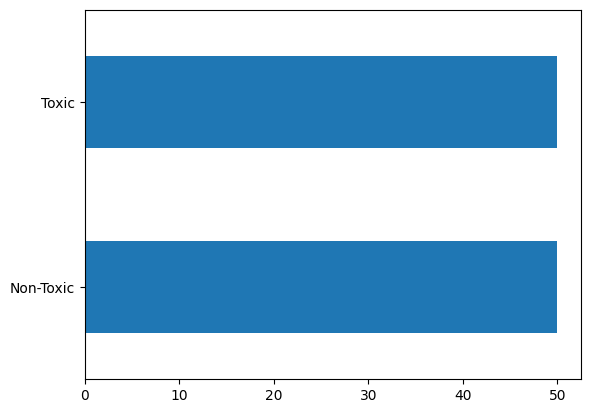

In [ ]:
multilingual_data["Labels"].value_counts().plot(kind="barh")
multilingual_data["Labels"].value_counts()

In [ ]:
multilingual_data["Language "].value_counts()

English       2
Lithuanian    2
Polish        2
Catalan       2
Czech         2
Hungarian     2
Albanian      2
Bulgarian     2
Hebrew        2
Slovenian     2
Romanian      2
Basque        2
Croatian      2
French        2
Estonian      2
Latvian       2
Slovak        2
Serbian       2
Macedonian    2
Frisian       2
Flemish       2
Breton        2
Irish         2
Ukrainian     2
Icelandic     2
Greek         2
Filipino      2
Malay         2
Spanish       2
German        2
Italian       2
Portuguese    2
Russian       2
Chinese       2
Arabic        2
Japanese      2
Korean        2
Turkish       2
Dutch         2
Swedish       2
Danish        2
Norwegian     2
Finnish       2
Swahili       2
Thai          2
Indonesian    2
Vietnamese    2
Hindi         2
Bengali       2
Belarusian    2
Name: Language , dtype: int64

### Verify data quality

In [ ]:
multilingual_data.isnull().sum()

Language        0
Sentences       0
Labels          0
Unnamed: 3    100
Languages      50
dtype: int64

### Preprocessing

In [ ]:
multilingual_data = multilingual_data[["Language ", "Sentences", "Labels"]]
multilingual_data

,Language,Sentences,Labels
0,English,The weather today is so beautiful.,Non-Toxic
1,English,"You're so stupid, you can't even understand th...",Toxic
2,French,Je suis heureux de te voir aujourd'hui.,Non-Toxic
3,French,"Tu es tellement ennuyeux, je regrette d'être v...",Toxic
4,Spanish,Me encanta la música clásica.,Non-Toxic
...,...,...,...
95,Irish,Is duine mór le rácais thú.,Toxic
96,Ukrainian,"Дякую за вашу допомогу, я дуже вам вдячний.",Non-Toxic
97,Ukrainian,Ти жодного разу не зможеш зробити це правильно.,Toxic
98,Belarusian,"Дзякуй за вашу дапамогу, я вельмі вас цаню.",Non-Toxic


In [ ]:
multilingual_data["Labels"] = (multilingual_data["Labels"] == "Toxic").astype(np.int32)
multilingual_data

<ipython-input-55-98413a30568e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multilingual_data["Labels"] = (multilingual_data["Labels"] == "Toxic").astype(np.int32)


,Language,Sentences,Labels
0,English,The weather today is so beautiful.,0
1,English,"You're so stupid, you can't even understand th...",1
2,French,Je suis heureux de te voir aujourd'hui.,0
3,French,"Tu es tellement ennuyeux, je regrette d'être v...",1
4,Spanish,Me encanta la música clásica.,0
...,...,...,...
95,Irish,Is duine mór le rácais thú.,1
96,Ukrainian,"Дякую за вашу допомогу, я дуже вам вдячний.",0
97,Ukrainian,Ти жодного разу не зможеш зробити це правильно.,1
98,Belarusian,"Дзякуй за вашу дапамогу, я вельмі вас цаню.",0


In [ ]:
multilingual_data = multilingual_data.rename(columns={"Sentences": "comment_text", "Labels": 0})
multilingual_data

,Language,comment_text,0
0,English,The weather today is so beautiful.,0
1,English,"You're so stupid, you can't even understand th...",1
2,French,Je suis heureux de te voir aujourd'hui.,0
3,French,"Tu es tellement ennuyeux, je regrette d'être v...",1
4,Spanish,Me encanta la música clásica.,0
...,...,...,...
95,Irish,Is duine mór le rácais thú.,1
96,Ukrainian,"Дякую за вашу допомогу, я дуже вам вдячний.",0
97,Ukrainian,Ти жодного разу не зможеш зробити це правильно.,1
98,Belarusian,"Дзякуй за вашу дапамогу, я вельмі вас цаню.",0


### Extract Embeddings

In [ ]:
ds_multilingual = MultiLabelDataset(multilingual_data.reset_index(drop=True), tokenizer, MAX_LEN)

In [ ]:
mutlilingual_ds_loader = DataLoader(ds_multilingual, **embedder_params)

In [ ]:
embeddings = []

with torch.no_grad():
    for _, data in tqdm(enumerate(mutlilingual_ds_loader)):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        outputs = model(input_ids=ids, attention_mask=mask).last_hidden_state.cpu().detach().numpy()
        for output in outputs:
            # print(outputs[0].sum(axis=0).shape)
            # print(outputs[0, :, 0].shape)
            # print(outputs[0].max(axis=0).shape)
            # print(outputs[0].max(axis=0))
            # raise Exception()
            embeddings.append(outputs[0].sum(axis=0))

len(embeddings), len(embeddings[0])

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
25it [00:00, 38.71it/s]


(100, 768)

In [ ]:
embeddings = pd.DataFrame(embeddings)
embeddings

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,32.208923,-3.004735,1.427745,0.362409,51.507965,-50.207161,-27.219048,1.597060,63.147732,0.134843,...,56.816410,35.608868,-0.114450,14.210971,5.625720,-15.473611,57.646011,61.320049,-18.652346,-11.918041
1,32.208923,-3.004735,1.427745,0.362409,51.507965,-50.207161,-27.219048,1.597060,63.147732,0.134843,...,56.816410,35.608868,-0.114450,14.210971,5.625720,-15.473611,57.646011,61.320049,-18.652346,-11.918041
2,32.208923,-3.004735,1.427745,0.362409,51.507965,-50.207161,-27.219048,1.597060,63.147732,0.134843,...,56.816410,35.608868,-0.114450,14.210971,5.625720,-15.473611,57.646011,61.320049,-18.652346,-11.918041
3,32.208923,-3.004735,1.427745,0.362409,51.507965,-50.207161,-27.219048,1.597060,63.147732,0.134843,...,56.816410,35.608868,-0.114450,14.210971,5.625720,-15.473611,57.646011,61.320049,-18.652346,-11.918041
4,5.455412,-15.249132,77.529831,38.122826,37.661537,9.358280,24.520336,-29.208527,55.153606,66.950180,...,14.603143,37.123222,21.634983,-72.106285,-45.672600,-7.936017,24.188330,4.756918,-0.289130,-48.895527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,10.540078,13.084940,10.015375,-16.268213,89.364212,-20.889158,-23.003119,-19.991144,-3.546121,32.258984,...,-28.690157,31.501383,18.987474,-83.535530,55.746258,11.819826,37.539276,-31.588428,27.417021,10.186622
96,26.807709,-10.783205,68.641602,-16.928495,48.251480,-4.305695,-53.231686,15.289906,-18.020582,47.331158,...,-2.400949,-19.311735,-2.065155,-18.712212,44.788803,-2.794674,-3.614145,-61.021210,23.081337,32.133663
97,26.807709,-10.783205,68.641602,-16.928495,48.251480,-4.305695,-53.231686,15.289906,-18.020582,47.331158,...,-2.400949,-19.311735,-2.065155,-18.712212,44.788803,-2.794674,-3.614145,-61.021210,23.081337,32.133663
98,26.807709,-10.783205,68.641602,-16.928495,48.251480,-4.305695,-53.231686,15.289906,-18.020582,47.331158,...,-2.400949,-19.311735,-2.065155,-18.712212,44.788803,-2.794674,-3.614145,-61.021210,23.081337,32.133663


In [ ]:
# embeddings = sd_scaler.transform(embeddings)
# embeddings

In [ ]:
pd.DataFrame(embeddings)

In [ ]:
embeddings.columns = [f"emb_{i}" for i in range(embeddings.shape[1])]

In [ ]:
embedded_eval = pd.concat([embeddings, multilingual_data[0].reset_index(drop=True)], axis=1).rename(columns={0: "is_toxic"})
del embeddings
embedded_eval

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_759,emb_760,emb_761,emb_762,emb_763,emb_764,emb_765,emb_766,emb_767,is_toxic
0,32.208923,-3.004735,1.427745,0.362409,51.507965,-50.207161,-27.219048,1.597060,63.147732,0.134843,...,35.608868,-0.114450,14.210971,5.625720,-15.473611,57.646011,61.320049,-18.652346,-11.918041,0
1,32.208923,-3.004735,1.427745,0.362409,51.507965,-50.207161,-27.219048,1.597060,63.147732,0.134843,...,35.608868,-0.114450,14.210971,5.625720,-15.473611,57.646011,61.320049,-18.652346,-11.918041,1
2,32.208923,-3.004735,1.427745,0.362409,51.507965,-50.207161,-27.219048,1.597060,63.147732,0.134843,...,35.608868,-0.114450,14.210971,5.625720,-15.473611,57.646011,61.320049,-18.652346,-11.918041,0
3,32.208923,-3.004735,1.427745,0.362409,51.507965,-50.207161,-27.219048,1.597060,63.147732,0.134843,...,35.608868,-0.114450,14.210971,5.625720,-15.473611,57.646011,61.320049,-18.652346,-11.918041,1
4,5.455412,-15.249132,77.529831,38.122826,37.661537,9.358280,24.520336,-29.208527,55.153606,66.950180,...,37.123222,21.634983,-72.106285,-45.672600,-7.936017,24.188330,4.756918,-0.289130,-48.895527,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,10.540078,13.084940,10.015375,-16.268213,89.364212,-20.889158,-23.003119,-19.991144,-3.546121,32.258984,...,31.501383,18.987474,-83.535530,55.746258,11.819826,37.539276,-31.588428,27.417021,10.186622,1
96,26.807709,-10.783205,68.641602,-16.928495,48.251480,-4.305695,-53.231686,15.289906,-18.020582,47.331158,...,-19.311735,-2.065155,-18.712212,44.788803,-2.794674,-3.614145,-61.021210,23.081337,32.133663,0
97,26.807709,-10.783205,68.641602,-16.928495,48.251480,-4.305695,-53.231686,15.289906,-18.020582,47.331158,...,-19.311735,-2.065155,-18.712212,44.788803,-2.794674,-3.614145,-61.021210,23.081337,32.133663,1
98,26.807709,-10.783205,68.641602,-16.928495,48.251480,-4.305695,-53.231686,15.289906,-18.020582,47.331158,...,-19.311735,-2.065155,-18.712212,44.788803,-2.794674,-3.614145,-61.021210,23.081337,32.133663,0


### Evaluation of classifiers

#### DecisionTreeClassifier

In [ ]:
score = dt_clf.score(embedded_eval.drop("is_toxic", axis=1).values, embedded_eval["is_toxic"])
score

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


0.5

#### GaussianNB

In [ ]:
score = nb_clf.score(embedded_eval.drop("is_toxic", axis=1), embedded_eval["is_toxic"])
score

0.5

#### Neural Net

In [ ]:
def eval_deep(model, X_val, y_val):
    X_val = torch.tensor(X_val.values, dtype=torch.float32)
    y_val = torch.tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)
    batch_size = 10  # size of each batch
    val_batch_start = torch.arange(0, len(X_val), batch_size)
    model.eval()
    val_acc = 0
    for start in val_batch_start:
        # take a batch
        X_batch = X_val[start:start+batch_size]
        y_batch = y_val[start:start+batch_size]
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(X_batch)
        acc = (y_pred.round() == y_batch).float().mean()
        acc = float(acc)
        val_acc += acc
    val_acc = val_acc / len(val_batch_start)
    return val_acc

In [ ]:
embedded_eval.drop("is_toxic", axis=1).shape

(100, 768)

In [ ]:
eval_deep(deep_model, embedded_eval.drop("is_toxic", axis=1), embedded_eval["is_toxic"])

0.5